# KRVFL 

Multiple Kernel Learning

### Mercer 定理

任何半正定的函数都可以作为核函数。所谓半正定的函数f(xi,xj)，是指拥有训练数据集合（x1,x2,...xn)，我们定义一个矩阵的元素aij = f(xi,xj)，这个矩阵式n*n的，如果这个矩阵是半正定的，那么f(xi,xj)就称为半正定的函数。这个mercer定理不是核函数必要条件，只是一个充分条件，即还有不满足mercer定理的函数也可以是核函数

### The MKLpy library

MKL algorithms

    EasyMKL
    RM-GD
    R-MKL
    Average of kernels
    a meta-MKL-classifier used in multiclass problems according to one-vs-one pattern;

tools to operate over kernels, such as normalization, centering, summation, mean...;

metrics, such as kernel_alignment, radius...;

kernel functions, such as HPK (Homogeneous Polynomial Kernel) and boolean kernels (disjunctive, conjunctive, DNF, CNF).

# Kernel-RVFL

Multi-kernel learning. a1K1(x1,x2) + a2K2(x1,x2) + a3K3(x1,x2) + ...  s.t. a1 + a2 + ... = 1.0

# Implementation

Based on https://github.com/pablozhang/RVFL_plus


Kernel RVFL 不包含权重或偏置参数的初始化，实为将原始特征转化为一个线性核变换(Gram Matrix)与一个非线性核变换的叠加。模型本身为单层NN，类似于(linear + rbf) SVM

In [20]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel, chi2_kernel, polynomial_kernel, \
                                        additive_chi2_kernel, laplacian_kernel

x1 = np.array([[1,2],[3,4],[1,-2],[3,0]])
x2 = np.array([[-1,1],[3,2]])
print(x1.shape, x2.shape)

# 返回Gram Matrix: n维欧式空间中任意k个向量之间两两的内积所组成的矩阵，称为这k个向量的格拉姆矩阵(Gram matrix)
linear_kernel(x1,x2), rbf_kernel(x1,x2) # 维度 = [x1_rows, x2_rows]

(4, 2) (2, 2)


(array([[ 1.,  7.],
        [ 1., 17.],
        [-3., -1.],
        [-3.,  9.]]), array([[8.20849986e-02, 1.35335283e-01],
        [3.72665317e-06, 1.35335283e-01],
        [1.50343919e-03, 4.53999298e-05],
        [2.03468369e-04, 1.35335283e-01]]))

## 案例1：一维数据的回归问题

(158, 1) (40, 1) (158, 1) (40, 1)


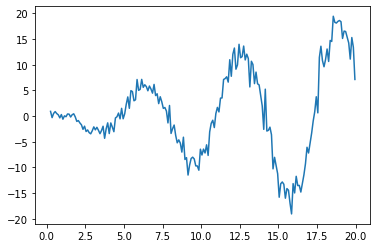

In [44]:
from sklearn.cluster import k_means
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# from elm import ELMClassifier, ELMRegressor, GenELMClassifier, GenELMRegressor
# from random_layer import RandomLayer, MLPRandomLayer, RBFRandomLayer, GRBFRandomLayer

def make_toy():
    x = np.arange(0.25,20,0.1)
    y = x*np.cos(x)+0.5*np.sqrt(x)*np.random.randn(x.shape[0])
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    return x, y

xtoy, ytoy = make_toy()
# xtoy, ytoy = stdsc.fit_transform(xtoy), stdsc.fit_transform(ytoy)
x_train, x_test, t_train, t_test = train_test_split(xtoy, ytoy, test_size=0.2)
plt.plot(xtoy, ytoy)
print(x_train.shape, x_test.shape, t_train.shape, t_test.shape)

MSE on test set =  65.59073818963508


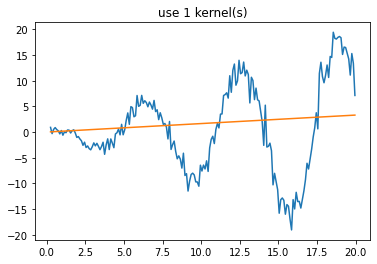

MSE on test set =  19.979850991883826


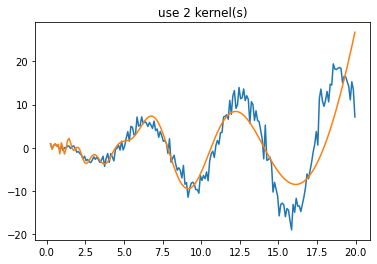

MSE on test set =  4.546179425432031


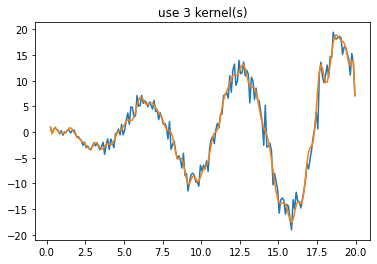

MSE on test set =  4.500715416852906


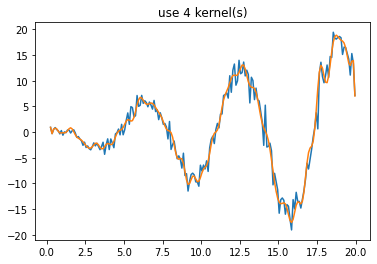

MSE on test set =  4.542163101440369


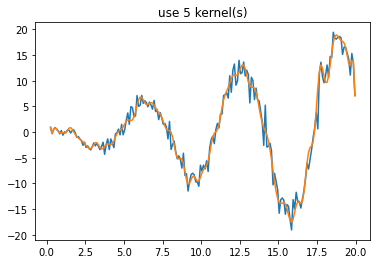

MSE on test set =  4.726925601641133


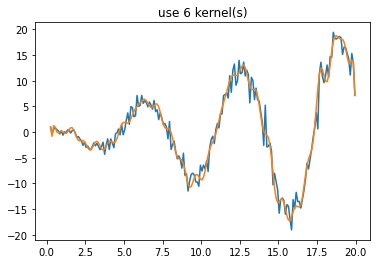

In [46]:
for k in range(1,7):

    rvfl = KRVFL(type='regression', kernels = k)
    rvfl.fit(x_train, t_train)
    t_pred = rvfl.predict(x_train, x_test) # unlike RVFL, KRVFL requires the training set as an input parameter
    MSE = np.mean((t_test - t_pred)**2)
    print("MSE on test set = ", MSE)
    plt.plot(xtoy, ytoy, xtoy, rvfl.predict(x_train, xtoy))
    plt.title('use ' + str(k) + ' kernel(s)')
    plt.show()

## 案例2： Iris Dataset

In [50]:
%run "../../machine learning/source/18. pyNNRW/github/src/pyNNRW/krvfl.py"

<Figure size 432x288 with 0 Axes>

In [60]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# ===============================
# Load dataset
# ===============================
iris = load_iris()
n_classes = len(set(iris.target))
# stdsc = StandardScaler()
# irisx = stdsc.fit_transform(iris.data)
x_train, x_test, t_train, t_test = train_test_split(iris.data, iris.target, test_size=0.2)
# RVFL internally converts y to one-hot-encoding
# t_train = to_categorical(t_train, n_classes).astype(np.float32)
# t_test = to_categorical(t_test, n_classes).astype(np.float32)
# print(x_train.shape, x_test.shape, t_train.shape, t_test.shape)

# ===============================
# Instantiate
# ===============================
clf = KRVFLClassifier(kernels = ['linear', "sigmoid", "rbf", "rbf" ])

# ===============================
# Training
# ===============================
clf.fit(x_train, t_train)
t_pred = clf.predict(x_train, x_train)
ACC = np.mean(t_train == t_pred)
print("ACC on training set = ", ACC)

# ===============================
# Validation
# ===============================
t_pred = clf.predict(x_train, x_test)
ACC = np.mean(t_test == t_pred)
print("ACC on test set = ", ACC)

the label must be reshaped before being transformed
ACC on training set =  1.0
ACC on test set =  0.9333333333333333


观察点：  
1. 由于没有类似于梯度下降的迭代过程，求解速度极快